In [ ]:
from utils.data_loader import generate_gaussian_modes
from training.train_GAN import train_Basic2DGAN, train_Dia2DGAN
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision import transforms
from evaluation.metrics import evaluate_mode_coverage, compute_precision_recall_2D
from models import MLPGAN
import torch
import pandas as pd


In [52]:

def run_experiment(model_name, train_fn, n_runs=5, latent_dim=10, k = None, ratio = 0.9, data=None):
    results = []
    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs} — {model_name}")

        # Init fresh models
        gen = MLPGAN.Generator(latent_dim)
        disc = MLPGAN.Discriminator()

        # Train model
        if k is not None:
            trained_gen = train_fn(gen, disc, data, k, ratio)
        else:
            trained_gen = train_fn(gen, disc, data)

        # Evaluate
        with torch.no_grad():
            z = torch.randn(10000, latent_dim)
            gen_samples = trained_gen(z).cpu().numpy()

        prec, rec = compute_precision_recall_2D(data, gen_samples, k=5)
        coverage = evaluate_mode_coverage(gen_samples, real_centers=np.array([(x, y) for x in range(5) for y in range(5)]))

        results.append({
            "Run": run + 1,
            "Model": model_name,
            "Precision": prec,
            "Recall": rec,
            "Coverage": coverage
        })

    return results

def train_basic_wrapper(gen, disc, data):
    tensor_data = torch.tensor(data, dtype=torch.float32)
    dataloader = DataLoader(TensorDataset(tensor_data, tensor_data), batch_size=128, shuffle=True)
    train_Basic2DGAN(gen, disc, dataloader, latent_dim=10, n_epochs=100)
    return gen

def train_dia_wrapper(gen, disc, data, k, ratio=0.9):
    return train_Dia2DGAN(gen, disc, data, latent_dim=10, n_epochs=100, phase1_ratio=ratio, k=k)


In [53]:

X, y= generate_gaussian_modes()

# Run both experiments
results_dia_30 = run_experiment("DiaGAN ratio=0.3", train_dia_wrapper, k=0.5, ratio=0.3, data=X)
results_dia_50 = run_experiment("DiaGAN ratio=0.5", train_dia_wrapper, k=0.5, ratio=0.5, data=X)
results_dia_80 = run_experiment("DiaGAN ratio=0.8", train_dia_wrapper, k=0.5, ratio=0.8, data=X)
results_dia_90 = run_experiment("DiaGAN ratio=0.9", train_dia_wrapper, k=0.5, ratio=0.9, data=X)


# Combine results
all_results_ratio = pd.DataFrame(results_dia_30 + results_dia_50 + results_dia_80 + results_dia_90)

# Save or inspect
#all_results.to_csv("gan_comparison_results.csv", index=False)
display(all_results_ratio.groupby("Model").mean())


Run 1/5 — DiaGAN ratio=0.3
[Epoch 0] D Loss: 1.8638 | G Loss: 0.9692
[Epoch 50] D Loss: 1.1920 | G Loss: 0.8284
Run 2/5 — DiaGAN ratio=0.3
[Epoch 0] D Loss: 1.9969 | G Loss: 0.4963
[Epoch 50] D Loss: 1.1530 | G Loss: 0.9494
Run 3/5 — DiaGAN ratio=0.3
[Epoch 0] D Loss: 1.3367 | G Loss: 0.7693
[Epoch 50] D Loss: 1.2369 | G Loss: 1.0574
Run 4/5 — DiaGAN ratio=0.3
[Epoch 0] D Loss: 1.0884 | G Loss: 0.9954
[Epoch 50] D Loss: 0.9968 | G Loss: 0.9783
Run 5/5 — DiaGAN ratio=0.3
[Epoch 0] D Loss: 1.6478 | G Loss: 1.1061
[Epoch 50] D Loss: 1.3266 | G Loss: 0.7492
Run 1/5 — DiaGAN ratio=0.5
[Epoch 0] D Loss: 1.0326 | G Loss: 0.9227
[Epoch 50] D Loss: 1.2673 | G Loss: 0.6817
Run 2/5 — DiaGAN ratio=0.5
[Epoch 0] D Loss: 1.1118 | G Loss: 0.8689
[Epoch 50] D Loss: 1.2255 | G Loss: 1.0906
Run 3/5 — DiaGAN ratio=0.5
[Epoch 0] D Loss: 1.5112 | G Loss: 0.7447
[Epoch 50] D Loss: 1.1217 | G Loss: 0.9117
Run 4/5 — DiaGAN ratio=0.5
[Epoch 0] D Loss: 1.4664 | G Loss: 0.7236
[Epoch 50] D Loss: 1.2574 | G Loss:

,Run,Precision,Recall,Coverage
Model,,,,
DiaGAN ratio=0.3,3.0,0.52748,0.718160,12.0
DiaGAN ratio=0.5,3.0,0.63918,0.838336,19.4
DiaGAN ratio=0.8,3.0,0.57300,0.802144,19.4
DiaGAN ratio=0.9,3.0,0.45274,0.795472,18.6


In [56]:
X, y= generate_gaussian_modes()

# Run both experiments
results_basic = run_experiment("BasicGAN", train_basic_wrapper, data=X)
results_dia_0 = run_experiment("DiaGAN k=0.0", train_dia_wrapper, k=0.0, ratio=0.5, data=X)
results_dia_03 = run_experiment("DiaGAN k=0.3", train_dia_wrapper, k=0.3, ratio=0.5, data=X)
results_dia_05 = run_experiment("DiaGAN k=0.5", train_dia_wrapper, k=0.5, ratio=0.5, data=X)
results_dia_10 = run_experiment("DiaGAN k=1.0", train_dia_wrapper, k=1.0, ratio=0.5, data=X)
results_dia_20 = run_experiment("DiaGAN k=2.0", train_dia_wrapper, k=2.0, ratio=0.5, data=X)

# Combine results
all_results = pd.DataFrame(results_basic + results_dia_0 + results_dia_03 + results_dia_05 + results_dia_10 + results_dia_20)

# Save or inspect
#all_results.to_csv("gan_comparison_results.csv", index=False)
display(all_results.groupby("Model").mean())




Run 1/5 — BasicGAN
Run 2/5 — BasicGAN
Run 3/5 — BasicGAN
Run 4/5 — BasicGAN
Run 5/5 — BasicGAN
Run 1/5 — DiaGAN k=0.0
[Epoch 0] D Loss: 1.1636 | G Loss: 0.9314
[Epoch 50] D Loss: 1.0593 | G Loss: 1.5631
Run 2/5 — DiaGAN k=0.0
[Epoch 0] D Loss: 1.3372 | G Loss: 0.6151
[Epoch 50] D Loss: 1.0415 | G Loss: 1.0267
Run 3/5 — DiaGAN k=0.0
[Epoch 0] D Loss: 1.3954 | G Loss: 0.7869
[Epoch 50] D Loss: 1.0283 | G Loss: 1.2711
Run 4/5 — DiaGAN k=0.0
[Epoch 0] D Loss: 1.3517 | G Loss: 0.8407
[Epoch 50] D Loss: 1.1882 | G Loss: 0.9171
Run 5/5 — DiaGAN k=0.0
[Epoch 0] D Loss: 0.9493 | G Loss: 1.3132
[Epoch 50] D Loss: 1.2386 | G Loss: 0.8092
Run 1/5 — DiaGAN k=0.3
[Epoch 0] D Loss: 1.8081 | G Loss: 0.7253
[Epoch 50] D Loss: 1.1059 | G Loss: 1.0956
Run 2/5 — DiaGAN k=0.3
[Epoch 0] D Loss: 1.7021 | G Loss: 0.5817
[Epoch 50] D Loss: 1.0606 | G Loss: 1.2247
Run 3/5 — DiaGAN k=0.3
[Epoch 0] D Loss: 1.7275 | G Loss: 0.5664
[Epoch 50] D Loss: 1.1683 | G Loss: 1.2978
Run 4/5 — DiaGAN k=0.3
[Epoch 0] D Loss: 

,Run,Precision,Recall,Coverage
Model,,,,
BasicGAN,3.0,0.51888,0.852608,19.6
DiaGAN k=0.0,3.0,0.63760,0.819712,15.6
DiaGAN k=0.3,3.0,0.60038,0.818848,16.6
DiaGAN k=0.5,3.0,0.62334,0.788272,17.0
DiaGAN k=1.0,3.0,0.54594,0.846656,20.6
DiaGAN k=2.0,3.0,0.52100,0.804464,19.4


In [58]:
X, y= generate_gaussian_modes()

# Run both experiments
results_basic = run_experiment("BasicGAN", train_basic_wrapper, data=X)
results_dia_03 = run_experiment("DiaGAN k=0.3", train_dia_wrapper, k=0.3, ratio=0.5, data=X)
results_dia_05 = run_experiment("DiaGAN k=0.5", train_dia_wrapper, k=0.5, ratio=0.5, data=X)
results_dia_10 = run_experiment("DiaGAN k=1.0", train_dia_wrapper, k=1.0, ratio=0.5, data=X)
# Combine results
all_results = pd.DataFrame(results_basic + results_dia_03 + results_dia_05 + results_dia_10)

# Save or inspect
#all_results.to_csv("gan_comparison_results.csv", index=False)
display(all_results.groupby("Model").mean())


Run 1/5 — BasicGAN
Run 2/5 — BasicGAN
Run 3/5 — BasicGAN
Run 4/5 — BasicGAN
Run 5/5 — BasicGAN
Run 1/5 — DiaGAN k=0.3
[Epoch 0] D Loss: 1.1707 | G Loss: 0.9000
[Epoch 50] D Loss: 0.9204 | G Loss: 1.4511
Run 2/5 — DiaGAN k=0.3
[Epoch 0] D Loss: 1.5519 | G Loss: 0.4909
[Epoch 50] D Loss: 0.9492 | G Loss: 1.2519
Run 3/5 — DiaGAN k=0.3
[Epoch 0] D Loss: 1.1195 | G Loss: 1.1103
[Epoch 50] D Loss: 0.8837 | G Loss: 1.4045
Run 4/5 — DiaGAN k=0.3
[Epoch 0] D Loss: 1.0239 | G Loss: 0.9513
[Epoch 50] D Loss: 1.3454 | G Loss: 0.6028
Run 5/5 — DiaGAN k=0.3
[Epoch 0] D Loss: 1.1517 | G Loss: 0.9446
[Epoch 50] D Loss: 1.0104 | G Loss: 1.3120
Run 1/5 — DiaGAN k=0.5
[Epoch 0] D Loss: 1.2258 | G Loss: 0.9413
[Epoch 50] D Loss: 0.8170 | G Loss: 1.6430
Run 2/5 — DiaGAN k=0.5
[Epoch 0] D Loss: 1.7258 | G Loss: 0.7161
[Epoch 50] D Loss: 1.1337 | G Loss: 1.0699
Run 3/5 — DiaGAN k=0.5
[Epoch 0] D Loss: 1.1025 | G Loss: 1.0541
[Epoch 50] D Loss: 1.3015 | G Loss: 0.7334
Run 4/5 — DiaGAN k=0.5
[Epoch 0] D Loss: 

,Run,Precision,Recall,Coverage
Model,,,,
BasicGAN,3.0,0.51256,0.863568,20.8
DiaGAN k=0.3,3.0,0.64572,0.822784,17.4
DiaGAN k=0.5,3.0,0.63942,0.858448,18.2
DiaGAN k=1.0,3.0,0.49870,0.861648,21.0


 ### NOW on MNIST

In [33]:
from models import  SNGAN
from training.train_GAN import train_GPTBasicGAN
from collections import defaultdict
import torch.optim as optim

In [14]:
from torchvision import datasets
import os

In [15]:
def load_MNISTdata():
    data_dir = os.path.join(os.getcwd(), "..", "data", "raw")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Ensure [-1, 1] range
    ])

    train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root=data_dir, train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader

In [16]:

train_loader, _ = load_MNISTdata()

# --- Step 2: Initialize Your SNGAN Models ---
G = SNGAN.Generator(z_dim=100, img_channels=1)
D = SNGAN.Discriminator(img_channels=1)

# --- Step 3: Train Using Adapted BasicGAN Function ---
trained_G = train_GPTBasicGAN(
    generator=G,
    discriminator=D,
    dataloader=train_loader,
    lr=0.0002,
    latent_dim=100,
    n_epochs=50  # You can increase to 100–200 for better results
)



Epoch [1/50] | D Loss: 0.9817 | G Loss: 1.3879
Epoch [2/50] | D Loss: 1.2185 | G Loss: 0.9305
Epoch [3/50] | D Loss: 1.1924 | G Loss: 0.8665
Epoch [4/50] | D Loss: 1.3821 | G Loss: 0.7304
Epoch [5/50] | D Loss: 1.2819 | G Loss: 0.8491
Epoch [6/50] | D Loss: 1.3102 | G Loss: 0.7740
Epoch [7/50] | D Loss: 1.3488 | G Loss: 0.8069
Epoch [8/50] | D Loss: 1.2824 | G Loss: 0.7724
Epoch [9/50] | D Loss: 1.2776 | G Loss: 0.8480
Epoch [10/50] | D Loss: 1.3561 | G Loss: 0.7776
Epoch [11/50] | D Loss: 1.2582 | G Loss: 0.8435
Epoch [12/50] | D Loss: 1.3240 | G Loss: 0.7933
Epoch [13/50] | D Loss: 1.3364 | G Loss: 0.7431
Epoch [14/50] | D Loss: 1.3908 | G Loss: 0.7620
Epoch [15/50] | D Loss: 1.3131 | G Loss: 0.7697
Epoch [16/50] | D Loss: 1.3611 | G Loss: 0.7872
Epoch [17/50] | D Loss: 1.3647 | G Loss: 0.7753
Epoch [18/50] | D Loss: 1.3312 | G Loss: 0.7844
Epoch [19/50] | D Loss: 1.3287 | G Loss: 0.7850
Epoch [20/50] | D Loss: 1.3203 | G Loss: 0.7278
Epoch [21/50] | D Loss: 1.3205 | G Loss: 0.7136
E

In [18]:
from evaluation.evaluate_BasicGAN import generate_BasicGAN

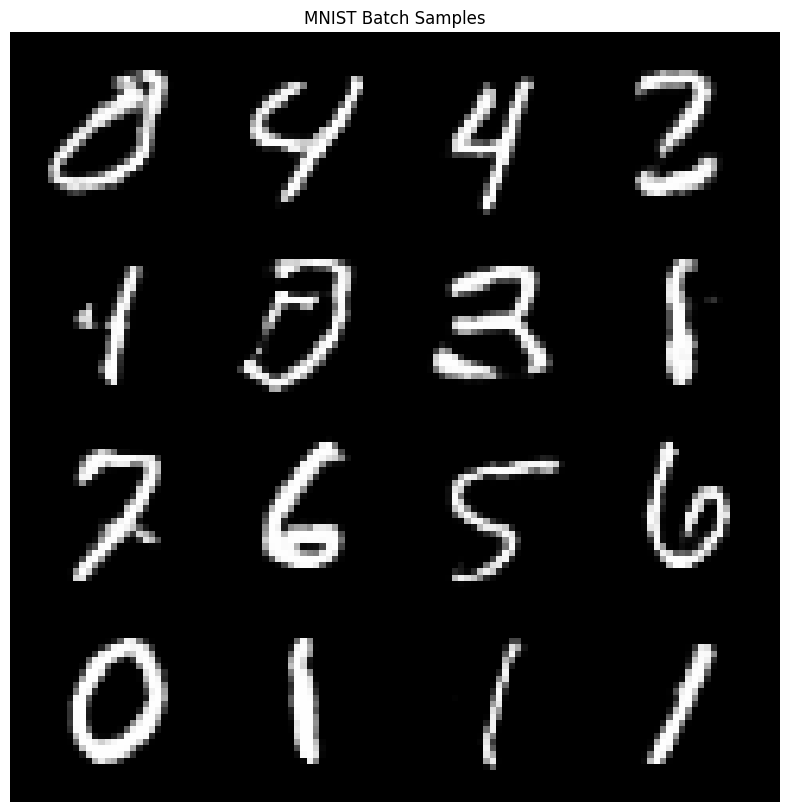

In [21]:
_=generate_BasicGAN(G, plotit=True)

In [36]:
import torch
from torch.utils.data import TensorDataset
import numpy as np

# --- Step 1: Load MNIST ---
train_loader, _ = load_MNISTdata()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Step 2: Convert DataLoader to TensorDataset for DiaGAN ---
# Because DiaGAN takes a tensor dataset, we convert all MNIST images to a single tensor
print("📦 Loading MNIST into memory...")
all_imgs = []
for imgs, _ in train_loader:
    all_imgs.append(imgs)
X_mnist = torch.cat(all_imgs, dim=0).numpy()  # Shape: (60000, 1, 28, 28)
print(f"✅ Loaded: {X_mnist.shape}")

# --- Step 3: Init Models (SNGAN-style) ---
G = SNGAN.Generator(z_dim=100, img_channels=1)
D = SNGAN.Discriminator(img_channels=1)

# --- Step 4: Train with DiaGAN ---
trained_G = train_DiaGAN(
    generator=G,
    discriminator=D,
    data=X_mnist,
    latent_dim=100,
    n_epochs=100,
    phase1_ratio=0.9,
    k=0.3,
    batch_size=64
)





📦 Loading MNIST into memory...
✅ Loaded: (60000, 1, 28, 28)
[Epoch 0] D Loss: 1.3308 | G Loss: 0.7207
[Epoch 10] D Loss: 1.3510 | G Loss: 0.7939
[Epoch 20] D Loss: 1.3510 | G Loss: 0.7124
[Epoch 30] D Loss: 1.3478 | G Loss: 0.7721
[Epoch 40] D Loss: 1.3565 | G Loss: 0.7638
[Epoch 50] D Loss: 1.3685 | G Loss: 0.7530
[Epoch 60] D Loss: 1.3841 | G Loss: 0.6892
[Epoch 70] D Loss: 1.3687 | G Loss: 0.7139
[Epoch 80] D Loss: 1.3584 | G Loss: 0.7478
[Epoch 90] D Loss: 1.3345 | G Loss: 0.7526


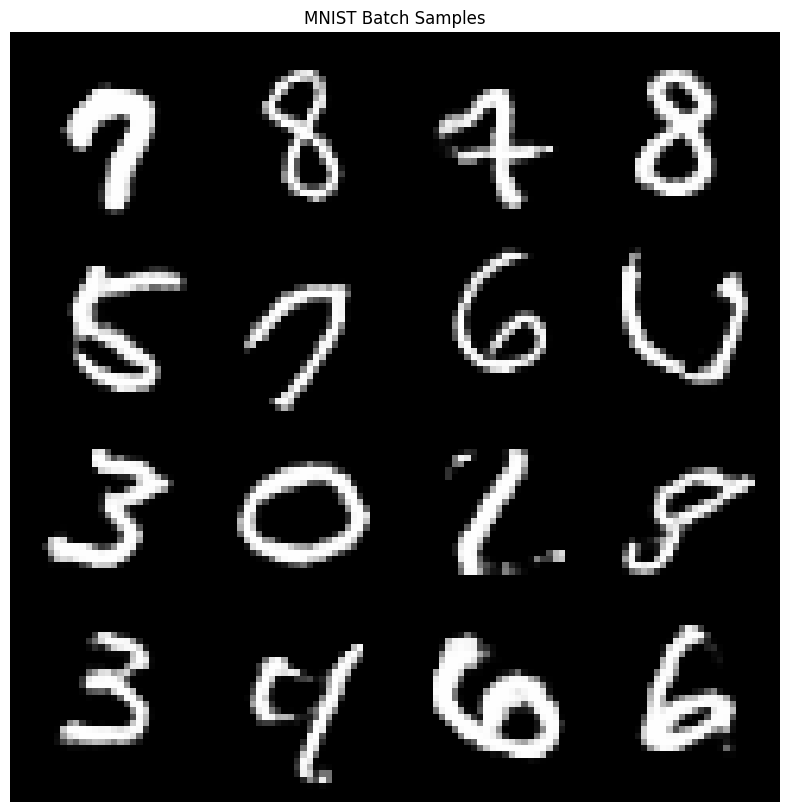

In [37]:
_=generate_BasicGAN(G, plotit=True)

### Posttraining DSR 

In [ ]:
def apply_DRS(generator, real_data, z_dim=100, num_gen=10000, batch_size=128, n_epochs=5):
    """
    Apply Discriminator Rejection Sampling (DRS)
    1. Train auxiliary discriminator on real vs fake
    2. Use it to score generated samples and accept/reject based on LDR
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare training data
    real_tensor = torch.tensor(real_data, dtype=torch.float32)
    real_labels = torch.ones(len(real_tensor), 1)
    real_ds = TensorDataset(real_tensor, real_labels)

    # Generate fake data
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_gen, z_dim, device=device)
        fake_tensor = generator(z).detach().cpu()
    fake_labels = torch.zeros(len(fake_tensor), 1)
    fake_ds = TensorDataset(fake_tensor, fake_labels)

    # Combine real and fake
    combined_data = torch.cat([real_tensor, fake_tensor], dim=0)
    combined_labels = torch.cat([real_labels, fake_labels], dim=0)
    loader = DataLoader(TensorDataset(combined_data, combined_labels), batch_size=batch_size, shuffle=True)

    # Train auxiliary discriminator
    aux_disc = SNGAN.Discriminator(img_channels=1).to(device) 
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(aux_disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

    print("📶 Training auxiliary discriminator for DRS...")
    aux_disc.train()
    for epoch in range(n_epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = aux_disc(x)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"[Epoch {epoch+1}] Aux D Loss: {loss.item():.4f}")
    aux_disc.eval()

    with torch.no_grad():
        logits = aux_disc(fake_tensor.to(device)).squeeze()
        probs = torch.sigmoid(logits)
        ldr = probs / (1 - probs + 1e-6)

    # Normalize and resample with probability ∝ LDR
    ldr_np = ldr.cpu().numpy()
    acceptance_probs = ldr_np / ldr_np.max()  # scale to [0, 1]
    accept_flags = np.random.rand(len(ldr_np)) < acceptance_probs

    filtered_samples = fake_tensor[accept_flags]
    print(f"🎯 DRS Accepted {len(filtered_samples)}/{num_gen} samples ({accept_flags.mean()*100:.2f}%)")
    return filtered_samples.numpy()


In [39]:
def dataloader_to_tensor(dataloader, max_samples=None):
    all_imgs = []
    for x, _ in dataloader:
        all_imgs.append(x)
        if max_samples and len(all_imgs) * x.size(0) >= max_samples:
            break
    return torch.cat(all_imgs, dim=0).numpy()

In [40]:
mnist_data = dataloader_to_tensor(train_loader, max_samples=10000)

In [41]:
filtered_samples = apply_DRS(
    generator=G,
    real_data=X_mnist,  # shape: (60000, 1, 28, 28)
    z_dim=100,
    num_gen=10000
)

📶 Training auxiliary discriminator for DRS...
[Epoch 1] Aux D Loss: 0.3653
[Epoch 2] Aux D Loss: 0.3262
[Epoch 3] Aux D Loss: 0.3389
[Epoch 4] Aux D Loss: 0.2944
[Epoch 5] Aux D Loss: 0.3474
🎯 DRS Accepted 596/10000 samples (5.96%)


In [47]:
def plot_samples_grid(samples, title="Generated Samples", n_rows=4, n_cols=4):
    """
    Plots a grid of generated MNIST-style images.
    
    Args:
        samples: numpy array or tensor of shape (N, 1, 28, 28) or (N, 28, 28)
        title: plot title
        n_rows, n_cols: grid dimensions
    """
    plt.figure(figsize=(n_cols, n_rows))
    for i in range(n_rows * n_cols):
        img = samples[i+12]
        if img.ndim == 3:
            img = img.squeeze()
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

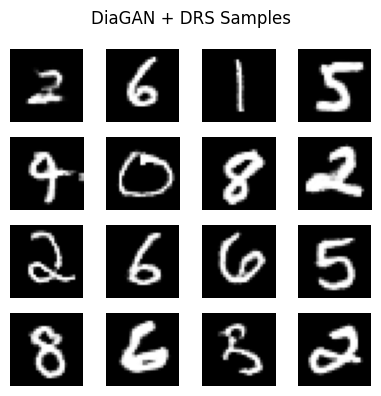

In [48]:
plot_samples_grid(filtered_samples, title="DiaGAN + DRS Samples")